# Annual Sentinel-2 Geomedian run with odc-stats

Useful links:
* [odc-stats](https://github.com/opendatacube/odc-stats)
* [crop-mask plugin](https://github.com/digitalearthafrica/crop-mask/blob/main/production/cm_tools/cm_tools/gm_ml_pred.py)
* [odc-algo geomedians](https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_geomedian.py#L337)
* [example geomedian config files](https://github.com/GeoscienceAustralia/dea-config/tree/09fa937a9c79e3505e85d2364a30bc002ca0c5f3/dev/services/odc-stats/geomedian)
* DEA-config for other [geomedians runs](https://github.com/GeoscienceAustralia/dea-config/tree/09fa937a9c79e3505e85d2364a30bc002ca0c5f3/dev/services/odc-stats/geomedian)

In [2]:
!pip uninstall s2_gm_tools -y
!pip install s2_gm_tools/

Found existing installation: s2-gm-tools 1.0.0
Uninstalling s2-gm-tools-1.0.0:
  Successfully uninstalled s2-gm-tools-1.0.0
Processing ./s2_gm_tools
  Preparing metadata (setup.py) ... done
  Created wheel for s2-gm-tools: filename=s2_gm_tools-1.0.0-py3-none-any.whl size=9526 sha256=b26f092cb1e4a75c6949c9cdd4155e81262be45a619ea712a1771cd416ad41fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-yk10h6wb/wheels/4e/ba/0e/f78ae9c2f6d8472eaed9090aa95acc9d2252f1e66a22e9b339
Successfully built s2-gm-tools


In [3]:
import os
import json
import warnings
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.stats.tasks import TaskReader
from odc.stats.model import OutputProduct

warnings.filterwarnings("ignore")

## Analysis Parameters

Some tile ids to run
* 'x43y14' # se aus forests Alps.
* 'x39y09' # West tassie
* 'x33y26' # Central Aus with salt lakes
* 'x31y43' # Tropical NT
* 'x19y18' # Esperance crops and sand dunes
* 'x42y38' # Qld tropical forests
* 'x39y13' # Melbourne city and bay+crops
* 'x12y19' # Perth City
* 'x41y12' # Complex coastal in Vic.

In [ ]:
# tiles = ['x30y34','x36y52','x61y30','x58y22','x57y28', 'x61y29', 'x64y32', 'x65y40', 'x60y53' ,'x55y51', 'x46y58', 'x46y46', 'x36y34']
# gdf = gpd.read_file('~/gdata1/projects/s2_gm/testing_tile_suite.geojson')

# gdf = gdf[gdf['region_code'].isin(tiles)]
# gdf.reset_index(drop=True).to_file('~/gdata1/projects/s2_gm/testing_tile_suite_13tiles.geojson')

In [4]:
year='2022' 
t = 19,18  # tile id to run i.e. x19y18
resolution = 100 # can coarsen resolution to run to speed up testing
products='ga_s2am_ard_3-ga_s2bm_ard_3-ga_s2cm_ard_3' # use all S2 observations
name, version = 'ga_s2_gm_cyear_3', '0-0-1' #product name and version
results = '/gdata1/projects/s2_gm/results/' #where are we outputting results?
ncpus=15
mem='115Gi'

## Save tasks database etc.

In [ ]:
os.system("odc-stats save-tasks "\
          "--grid au-10 "\
          f"--year {year} "\
          f"--input-products {products}"
         )

## Find the tile ID to run

We'll pass this index to odc-stats next to tell it to run this tile

In [5]:
## Open the task database to find out tiles
op = OutputProduct(
            name=name,
            version=version,
            short_name=name,
            location=f"s3://dummy-bucket/{name}/{version}",
            properties={"odc:file_format": "GeoTIFF"},
            measurements=['nbart_red'],
        )

taskdb = TaskReader(f'{products}_{year}--P1Y.db', product=op)
task = taskdb.load_task((f'{year}--P1Y', t[0], t[1]))

# Now find index of the tile we want to run
# We'll pass this index to odc-stats next to tell it to run this tile
tile_index_to_run = []
all_tiles = list(taskdb.all_tiles)
for i, index in zip(all_tiles, range(0, len(all_tiles))):
    if (i[1]==t[0]) & (i[2]==t[1]):
        tile_index_to_run.append(index)
        print(index)

341


### Optionally view tile to check location

The next cell will plot the tile extent on an interactive map so you can ensure its the tile you want to run.

In [ ]:
# with open('task_tile_check.geojson', 'w') as fh:
#     json.dump(task.geobox.extent.to_crs('epsg:4326').json, fh, indent=2)

gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[task.geobox.extent.to_crs('epsg:4326').geom])
gdf.explore()

## Run the geomedian algo using odc-stats

Put this link into the dask dashboard to view the progress, altering the email address to yours: https://app.sandbox.dea.ga.gov.au/user/chad.burton@ga.gov.au/proxy/8787/status

In [7]:
!pip uninstall s2_gm_tools -y
!pip install s2_gm_tools/

Found existing installation: s2-gm-tools 1.0.0
Uninstalling s2-gm-tools-1.0.0:
  Successfully uninstalled s2-gm-tools-1.0.0
Processing ./s2_gm_tools
  Preparing metadata (setup.py) ... done
  Created wheel for s2-gm-tools: filename=s2_gm_tools-1.0.0-py3-none-any.whl size=9526 sha256=dd0318f9dfbca50221115b97af601f0e397290bb313e6566dcd32d29fc9fbc03
  Stored in directory: /tmp/pip-ephem-wheel-cache-_n3giman/wheels/4e/ba/0e/f78ae9c2f6d8472eaed9090aa95acc9d2252f1e66a22e9b339
Successfully built s2-gm-tools


In [8]:
%%time
os.system("odc-stats run "\
          f"{products}_{year}--P1Y.db "\
          "--config=s2_gm_tools/s2_gm_tools/config/config_gm_s2_annual_s2Cloudless_enhanced.yaml "\
          f"--resolution={resolution} "\
          f"--threads={ncpus} "\
          f"--memory-limit={mem} "\
          f"--location=file:///home/jovyan/{results}{name}/{version} " +str(tile_index_to_run[0])
         )

[2025-05-22 06:13:11,476] {_cli_run.py:168} INFO - Config overrides: {'filedb': 'ga_s2am_ard_3-ga_s2bm_ard_3-ga_s2cm_ard_3_2022--P1Y.db', 'threads': 15, 'memory_limit': '115Gi', 'output_location': 'file:///home/jovyan//gdata1/projects/s2_gm/results/ga_s2_gm_cyear_3/0-0-1'}
[2025-05-22 06:13:11,477] {_cli_run.py:200} INFO - Using this config: TaskRunnerConfig(filedb='ga_s2am_ard_3-ga_s2bm_ard_3-ga_s2cm_ard_3_2022--P1Y.db', aws_unsigned=True, plugin='s2_gm_tools.s2_gm_plugin_refactor.GMS2AUS', plugin_config={'resampling': 'cubic', 'bands': ['nbart_red', 'nbart_green', 'nbart_blue'], 'rgb_bands': ['nbart_red', 'nbart_green', 'nbart_blue'], 'mask_band': 'oa_s2cloudless_mask', 'proba_band': 'oa_s2cloudless_prob', 'contiguity_band': 'oa_nbart_contiguity', 'nodata_classes': ['nodata'], 'cp_threshold': 0.1, 'aux_names': {'smad': 'smad', 'emad': 'emad', 'bcmad': 'bcmad', 'count': 'count'}}, product={'name': 'ga_s2_gm_cyear_3', 'short_name': 'ga_s2_gm_cyear_3', 'version': '0.0.1', 'product_famil

/env/lib/python3.10/site-packages/odc/algo/io.py:143: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xx = xx.set_xindex(groupby)
<string>:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of ti

[2025-05-22 06:23:25,320] {proc.py:287} INFO - Finished processing of x19/y18/2022--P1Y
[2025-05-22 06:23:25,321] {_cli_run.py:242} INFO - Finished task #1: x19/y18/2022--P1Y 7785d8ce-398b-5532-91e5-294e449255ee
[2025-05-22 06:23:25,321] {_cli_run.py:247} INFO - T:1, OK:1, S:0, E:0
[2025-05-22 06:23:25,321] {_cli_run.py:249} INFO - Completed processing 1 tasks, OK:1,
        S:0, E:0
[2025-05-22 06:23:25,322] {_cli_run.py:254} INFO - Shutting down Dask cluster
[2025-05-22 06:23:25,325] {_cli_run.py:260} INFO - Calling sys.exit(0)


2025-05-22 06:23:25,333 - distributed.scheduler - WARNING - Removing worker 'inproc://10.95.97.78/7065/4' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'_pack_write_result-d4c950d9-065f-4d32-a358-c0ad2f900d27'} (stimulus_id='handle-worker-cleanup-1747895005.3331418')


CPU times: user 64.4 ms, sys: 15.3 ms, total: 79.7 ms
Wall time: 10min 18s


0

## Plot the RGBA output

In [9]:
# t = 3,19  # tile id
name, version = 'ga_s2_gm_cyear_3', '0-0-1'
results = '/gdata1/projects/s2_gm/results/'

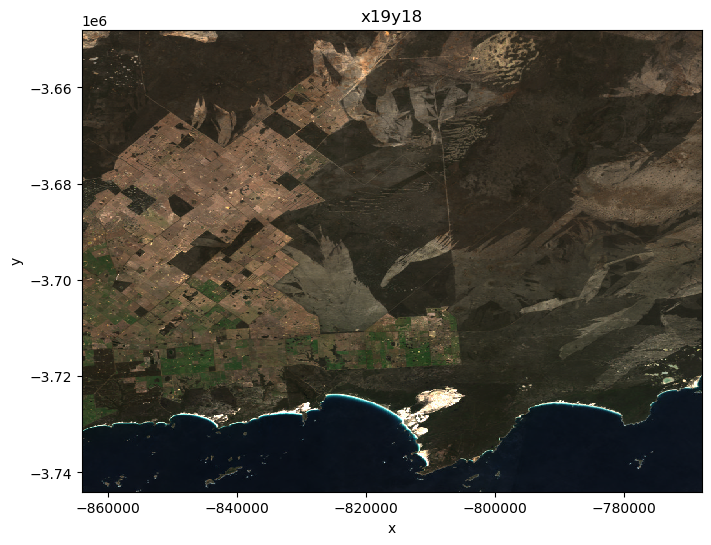

In [10]:
x= f'x{t[0]}'
y= f'y{t[1]}'

path = f'{results}{name}/{version}/{x}/{y}/{year}--P1Y/{name}_{x}{y}_{year}--P1Y_final_rgba.tif'
rgba=rxr.open_rasterio(path)
rgba=assign_crs(rgba, crs='EPSG:3577')

rgba.plot.imshow(size=6);
plt.title(x+y);

## Interactively explore results

In [11]:
red_path = f'{results}{name}/{version}/{x}/{y}/{year}--P1Y/{name}_{x}{y}_{year}--P1Y_final_nbart_red.tif'
green_path = f'{results}{name}/{version}/{x}/{y}/{year}--P1Y/{name}_{x}{y}_{year}--P1Y_final_nbart_green.tif'
blue_path = f'{results}{name}/{version}/{x}/{y}/{year}--P1Y/{name}_{x}{y}_{year}--P1Y_final_nbart_blue.tif'
count_path = f'{results}{name}/{version}/{x}/{y}/{year}--P1Y/{name}_{x}{y}_{year}--P1Y_final_count.tif'

r=assign_crs(rxr.open_rasterio(red_path).squeeze().drop_vars('band'),crs='EPSG:3577')
g=assign_crs(rxr.open_rasterio(green_path).squeeze().drop_vars('band'),crs='EPSG:3577')
b=assign_crs(rxr.open_rasterio(blue_path).squeeze().drop_vars('band'),crs='EPSG:3577')

r = r.rename('nbart_red')
g = g.rename('nbart_green')
b = b.rename('nbart_blue')

ds = assign_crs(xr.merge([r,g,b]), crs='EPSG:3577')

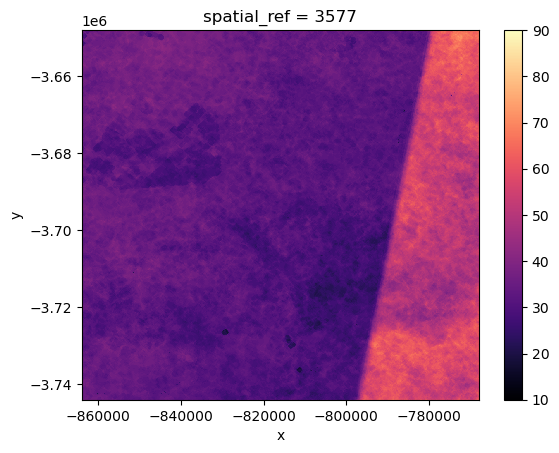

In [15]:
count=assign_crs(rxr.open_rasterio(count_path).squeeze().drop_vars('band'),crs='EPSG:3577')
count.plot(cmap='magma', vmin=10, vmax=90)

In [13]:
ds.odc.explore()

## Remove all files

In [1]:
!rm -r -f results/ga_s2_gm_cyear_3/